In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [4]:
# Cell: Prepare time-series sequences for TCN
# - Reads per-frame landmark CSVs (x_0,y_0,z_0,v_0 ... x_32,y_32,z_32,v_32)
# - Computes per-frame biomechanical features (21-ish)
# - Builds sliding-window sequences (seq_len, stride)
# - Saves X (npy), y (npy), and metadata CSV

import os
import glob
import math
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# ---- USER PARAMETERS (edit these) ----
KEYPOINT_CSV_FOLDER = r"C:\Users\user\Desktop\GaitLab\GaitLab\src\keypoints_csv"  
# folder containing per-video CSVs saved earlier (each row = frame, columns like x_0,y_0,z_0,v_0,...)

OUTPUT_TS_FOLDER = os.path.join(KEYPOINT_CSV_FOLDER, "ts_data")
os.makedirs(OUTPUT_TS_FOLDER, exist_ok=True)

SEQ_LEN = 64          # number of frames per sequence (adjust to approx 2-4 seconds depending on FPS)
STRIDE = 32           # sliding window stride (overlap = SEQ_LEN-STRIDE)
MIN_VALID_FRAMES = 10 # skip videos with too few valid frames after interpolation
SCALE_FEATURES = True # save scaler if True

# ---- Utility functions (angles & distances) ----
def calculate_angle_2d(a, b, c):
    """Angle in degrees for 2D points a-b-c (using x,y). Handles NaNs."""
    try:
        a = np.array(a[:2]); b = np.array(b[:2]); c = np.array(c[:2])
        ab = a - b; cb = c - b
        denom = (np.linalg.norm(ab) * np.linalg.norm(cb)) + 1e-8
        cosang = np.dot(ab, cb) / denom
        return float(np.degrees(np.arccos(np.clip(cosang, -1.0, 1.0))))
    except Exception:
        return np.nan

def euclidean(a, b):
    try:
        return float(np.linalg.norm(np.array(a[:3]) - np.array(b[:3])))
    except Exception:
        return np.nan

# ---- Which landmark indices to use (MediaPipe pose) ----
# (Using indices from earlier: shoulders 11/12, hips 23/24, knees 25/26, ankles 27/28, elbows 13/14/11/12 mapping slight variants)
# We'll follow the indices used earlier in your pipeline:
LEFT_SHOULDER, RIGHT_SHOULDER = 11, 12
LEFT_HIP, RIGHT_HIP = 23, 24
LEFT_KNEE, RIGHT_KNEE = 25, 26
LEFT_ANKLE, RIGHT_ANKLE = 27, 28
LEFT_ELBOW, RIGHT_ELBOW = 13, 14  # depending on your landmark indexing; adjust if needed
NOSE = 0

# ---- Feature computation per frame ----
def compute_frame_biomech_features(frame_row):
    """Given a single row (Series) of landmarks x_i, y_i, z_i, compute named features."""
    # Build landmarks array: list of [x,y,z]
    lm = []
    for i in range(33):
        x = frame_row.get(f"x_{i}", np.nan)
        y = frame_row.get(f"y_{i}", np.nan)
        z = frame_row.get(f"z_{i}", np.nan)
        lm.append([x, y, z])

    # angles (2D)
    left_knee = calculate_angle_2d(lm[LEFT_HIP], lm[LEFT_KNEE], lm[LEFT_ANKLE])
    right_knee = calculate_angle_2d(lm[RIGHT_HIP], lm[RIGHT_KNEE], lm[RIGHT_ANKLE])
    left_hip = calculate_angle_2d(lm[LEFT_SHOULDER], lm[LEFT_HIP], lm[LEFT_KNEE])
    right_hip = calculate_angle_2d(lm[RIGHT_SHOULDER], lm[RIGHT_HIP], lm[RIGHT_KNEE])
    left_elbow = calculate_angle_2d(lm[LEFT_SHOULDER], lm[LEFT_ELBOW], lm[LEFT_WRIST] if 'LEFT_WRIST' in globals() else lm[min(15,32)])
    right_elbow = calculate_angle_2d(lm[RIGHT_SHOULDER], lm[RIGHT_ELBOW], lm[min(16,32)])

    # distances
    shoulder_width = euclidean(lm[LEFT_SHOULDER], lm[RIGHT_SHOULDER])
    hip_width = euclidean(lm[LEFT_HIP], lm[RIGHT_HIP])
    step_length = euclidean(lm[LEFT_ANKLE], lm[RIGHT_ANKLE])  # proxy
    torso_length = euclidean(lm[LEFT_SHOULDER], lm[LEFT_HIP])
    leg_length_left = euclidean(lm[LEFT_HIP], lm[LEFT_ANKLE])
    leg_length_right = euclidean(lm[RIGHT_HIP], lm[RIGHT_ANKLE])

    # asymmetry / ratios
    knee_diff = np.nanmean([abs(left_knee - right_knee)]) if not (np.isnan(left_knee) or np.isnan(right_knee)) else np.nan
    hip_diff = np.nanmean([abs(left_hip - right_hip)]) if not (np.isnan(left_hip) or np.isnan(right_hip)) else np.nan
    leg_length_ratio = leg_length_left / (leg_length_right + 1e-8) if (not np.isnan(leg_length_left) and not np.isnan(leg_length_right)) else np.nan
    step_sym = abs(leg_length_left - leg_length_right) if (not np.isnan(leg_length_left) and not np.isnan(leg_length_right)) else np.nan

    # COM X (lateral COM) using shoulders+hips midpoint
    try:
        com_x = np.nanmean([lm[LEFT_SHOULDER][0], lm[RIGHT_SHOULDER][0], lm[LEFT_HIP][0], lm[RIGHT_HIP][0]])
    except:
        com_x = np.nan

    posture_deviation = abs(lm[NOSE][1] - np.nanmean([lm[LEFT_HIP][1], lm[RIGHT_HIP][1]])) if (not np.isnan(lm[NOSE][1])) else np.nan

    # Build dictionary - keep consistent names used before
    feat = {
        "left_knee_angle": left_knee,
        "right_knee_angle": right_knee,
        "left_hip_angle": left_hip,
        "right_hip_angle": right_hip,
        "left_elbow_angle": left_elbow,
        "right_elbow_angle": right_elbow,
        "shoulder_tilt": np.nan,  # optional: can be computed via 3-point angle if wanted
        "shoulder_width": shoulder_width,
        "hip_width": hip_width,
        "step_length": step_length,
        "torso_length": torso_length,
        "leg_length_left": leg_length_left,
        "leg_length_right": leg_length_right,
        "knee_angle_diff": knee_diff,
        "hip_angle_diff": hip_diff,
        "leg_length_ratio": leg_length_ratio,
        "step_symmetry": step_sym,
        "posture_deviation": posture_deviation,
        "shoulder_hip_ratio": shoulder_width / (hip_width + 1e-8) if not np.isnan(shoulder_width) and not np.isnan(hip_width) else np.nan,
        "limb_ratio": (leg_length_left + leg_length_right) / (torso_length + 1e-8) if not np.isnan(torso_length) else np.nan,
        "com_x": com_x
    }
    return feat

# ---- Loop through CSVs, compute per-frame features, and build sliding windows ----
all_X = []
all_y = []
meta_rows = []

csv_files = sorted([p for p in glob.glob(os.path.join(KEYPOINT_CSV_FOLDER, "*.csv")) if os.path.basename(p).lower().endswith(".csv")])

for csv_path in tqdm(csv_files, desc="Videos"):
    try:
        vid_df = pd.read_csv(csv_path)
    except Exception as e:
        print("Failed to read:", csv_path, e)
        continue

    # Skip if this is a single-row features CSV (Final_Gait_Features...), we want per-frame landmarks
    # We detect per-frame CSV by presence of x_0 (no _mean suffix)
    if not any(col.startswith("x_") for col in vid_df.columns):
        # skip aggregated files
        continue

    # Fill / interpolate missing frames
    vid_df = vid_df.interpolate(limit_direction='both', axis=0).fillna(method='bfill').fillna(method='ffill')

    # Determine label (prefer 'label' column; otherwise infer from filename)
    label = vid_df['label'].iloc[0] if 'label' in vid_df.columns else os.path.basename(os.path.dirname(csv_path))

    # Compute per-frame biomechanical features
    feats_list = []
    for idx in range(len(vid_df)):
        feats_list.append(compute_frame_biomech_features(vid_df.iloc[idx]))

    feats_df = pd.DataFrame(feats_list)
    # drop frames where all are nan
    feats_df = feats_df.dropna(how='all')
    if len(feats_df) < MIN_VALID_FRAMES:
        print(f"Skipping {os.path.basename(csv_path)} (too few valid frames: {len(feats_df)})")
        continue

    # Convert to numpy (frames x features)
    feat_cols = list(feats_df.columns)
    X_frames = feats_df[feat_cols].values.astype(float)  # shape (T, F)

    # Normalize per-feature across this video? We'll save global scaler later - but keep raw for now
    # Sliding windows
    T = X_frames.shape[0]
    for start in range(0, max(1, T - SEQ_LEN + 1), STRIDE):
        end = start + SEQ_LEN
        if end > T:
            break
        seq = X_frames[start:end, :]  # shape (SEQ_LEN, F)
        # skip sequences with too many NaNs
        if np.isnan(seq).mean() > 0.2:
            continue
        all_X.append(seq)
        all_y.append(label)
        meta_rows.append({
            "video_file": os.path.basename(csv_path),
            "start_frame": start,
            "end_frame": end,
            "label": label
        })

# Convert to arrays
if len(all_X) == 0:
    raise RuntimeError("No sequences generated. Check KEYPOINT_CSV_FOLDER and that CSVs are per-frame keypoint files.")

X_arr = np.stack(all_X, axis=0)  # (N_samples, SEQ_LEN, F)
y_arr = np.array(all_y)

print(f"Generated {X_arr.shape[0]} sequences; each seq shape = {X_arr.shape[1:]} (timesteps, features).")
print("Labels distribution:")
print(pd.Series(y_arr).value_counts())

# ---- Optionally scale features globally (fit scaler on all frames across all sequences) ----
if SCALE_FEATURES:
    nsamples, nt, nf = X_arr.shape
    X_2d = X_arr.reshape(-1, nf)  # (nsamples*nt, nf)
    scaler = StandardScaler()
    scaler.fit(X_2d)
    X_2d_scaled = scaler.transform(X_2d)
    X_arr_scaled = X_2d_scaled.reshape(nsamples, nt, nf)
    # replace X_arr with scaled
    X_arr = X_arr_scaled
    joblib.dump(scaler, os.path.join(OUTPUT_TS_FOLDER, "scaler.joblib"))
    print("Saved feature scaler.")

# ---- Save outputs ----
np.save(os.path.join(OUTPUT_TS_FOLDER, f"X_seq_len{SEQ_LEN}_stride{STRIDE}.npy"), X_arr.astype(np.float32))
np.save(os.path.join(OUTPUT_TS_FOLDER, f"y_seq_len{SEQ_LEN}_stride{STRIDE}.npy"), y_arr)
pd.DataFrame(meta_rows).to_csv(os.path.join(OUTPUT_TS_FOLDER, f"meta_seq_len{SEQ_LEN}_stride{STRIDE}.csv"), index=False)

print("Saved time-series dataset to:", OUTPUT_TS_FOLDER)
print("Done. Run next cell to inspect sample shapes or to create train/test splits.")


Videos:   0%|          | 0/252 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_14160\1331710094.py:144: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  vid_df = vid_df.interpolate(limit_direction='both', axis=0).fillna(method='bfill').fillna(method='ffill')
C:\Users\user\AppData\Local\Temp\ipykernel_14160\1331710094.py:144: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vid_df = vid_df.interpolate(limit_direction='both', axis=0).fillna(method='bfill').fillna(method='ffill')
Videos:   0%|          | 1/252 [00:00<03:51,  1.08it/s]C:\Users\user\AppData\Local\Temp\ipykernel_14160\1331710094.py:144: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  

Generated 2204 sequences; each seq shape = (64, 21) (timesteps, features).
Labels distribution:
KOA_Severe      634
KOA_Mild        506
KOA_Early       336
PD_Early        213
Normal          208
PD_Mild         170
PD_Severe        57
NonAssistive     55
Assistive        25
Name: count, dtype: int64
Saved feature scaler.
Saved time-series dataset to: C:\Users\user\Desktop\GaitLab\GaitLab\src\keypoints_csv\ts_data
Done. Run next cell to inspect sample shapes or to create train/test splits.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import joblib


In [9]:
X_PATH = r"C:\Users\user\Desktop\GaitLab\GaitLab\src\keypoints_csv\ts_data\X_seq_len64_stride32.npy"
y_PATH = r"C:\Users\user\Desktop\GaitLab\GaitLab\src\keypoints_csv\ts_data\y_seq_len64_stride32.npy"

import numpy as np

# Load sequences and labels
X = np.load(X_PATH, allow_pickle=True)
y = np.load(y_PATH, allow_pickle=True)

print("Sequences shape:", X.shape)
print("Labels shape:", y.shape)




Sequences shape: (2204, 64, 21)
Labels shape: (2204,)


In [11]:
# --- Cell: Handle NaNs, scale features, and split data ---
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle NaNs: impute with median per feature across all sequences
for feature_idx in range(X.shape[2]):
    feature_values = X[:, :, feature_idx]
    median_val = np.nanmedian(feature_values)
    feature_values[np.isnan(feature_values)] = median_val
    X[:, :, feature_idx] = feature_values

print("NaNs handled.")

# Flatten sequences for scaling (StandardScaler works on 2D arrays)
num_sequences, seq_len, num_features = X.shape
X_flat = X.reshape(num_sequences * seq_len, num_features)

# Scale features
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# Reshape back to (num_sequences, seq_len, num_features)
X_scaled = X_flat_scaled.reshape(num_sequences, seq_len, num_features)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



C:\Users\user\AppData\Local\Temp\ipykernel_14160\195201759.py:9: RuntimeWarning: All-NaN slice encountered
  median_val = np.nanmedian(feature_values)


NaNs handled.
X_train shape: (1763, 64, 21)
X_test shape: (441, 64, 21)
y_train shape: (1763,)
y_test shape: (441,)


c:\Users\user\Desktop\GaitLab\GaitEnv\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\user\Desktop\GaitLab\GaitEnv\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\user\Desktop\GaitLab\GaitEnv\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [12]:
# --- Cell: Define a simple TCN model for gait classification ---
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, GlobalAveragePooling1D, Dense

def build_tcn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 1️⃣ Temporal Convolution Block 1
    x = Conv1D(filters=64, kernel_size=3, padding='causal', dilation_rate=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # 2️⃣ Temporal Convolution Block 2
    x = Conv1D(filters=64, kernel_size=3, padding='causal', dilation_rate=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # 3️⃣ Temporal Convolution Block 3
    x = Conv1D(filters=64, kernel_size=3, padding='causal', dilation_rate=4)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # Global pooling & output
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build model
num_classes = len(np.unique(y))
model = build_tcn_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 21)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 64)         │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,153 (117.79 KB)

 Trainable params: 29,769 (116.29 KB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Step 1: Handle NaNs/Infs ---
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# --- Step 2: Encode labels ---
le = LabelEncoder()
y_enc = le.fit_transform(y)

# --- Step 3: Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# --- Step 4: Flatten, scale, reshape ---
num_sequences, seq_len, num_features = X_train.shape
X_train_flat = X_train.reshape(num_sequences*seq_len, num_features)
X_test_flat = X_test.reshape(X_test.shape[0]*seq_len, num_features)

scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_test_scaled_flat = scaler.transform(X_test_flat)

X_train_scaled = X_train_scaled_flat.reshape(num_sequences, seq_len, num_features)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape[0], seq_len, num_features)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# --- Step 5: Build TCN model ---
num_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=(seq_len, num_features)),
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    
    GlobalAveragePooling1D(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 6: Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_tcn_model.keras', monitor='val_loss', save_best_only=True)

# --- Step 7: Train model ---
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, checkpoint],
    verbose=2
)



X_train shape: (1763, 64, 21)
X_test shape: (441, 64, 21)
y_train shape: (1763,)
y_test shape: (441,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 64, 64)         │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 64, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 64, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,153 (117.79 KB)

 Trainable params: 29,769 (116.29 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
89/89 - 8s - 95ms/step - accuracy: 0.3574 - loss: 1.8074 - val_accuracy: 0.4703 - val_loss: 1.6789
Epoch 2/50
89/89 - 2s - 18ms/step - accuracy: 0.4965 - loss: 1.3785 - val_accuracy: 0.4646 - val_loss: 1.3427
Epoch 3/50
89/89 - 1s - 16ms/step - accuracy: 0.5504 - loss: 1.2417 - val_accuracy: 0.5326 - val_loss: 1.2209
Epoch 4/50
89/89 - 1s - 14ms/step - accuracy: 0.5809 - loss: 1.1710 - val_accuracy: 0.5637 - val_loss: 1.1366
Epoch 5/50
89/89 - 2s - 24ms/step - accuracy: 0.5901 - loss: 1.1138 - val_accuracy: 0.5892 - val_loss: 1.0621
Epoch 6/50
89/89 - 2s - 22ms/step - accuracy: 0.6092 - loss: 1.0701 - val_accuracy: 0.5836 - val_loss: 1.0795
Epoch 7/50
89/89 - 3s - 31ms/step - accuracy: 0.6213 - loss: 1.0186 - val_accuracy: 0.6006 - val_loss: 1.0422
Epoch 8/50
89/89 - 2s - 23ms/step - accuracy: 0.6404 - loss: 0.9819 - val_accuracy: 0.6204 - val_loss: 1.0203
Epoch 9/50
89/89 - 2s - 18ms/step - accuracy: 0.6440 - loss: 0.9668 - val_accuracy: 0.6261 - val_loss: 0.9818
Epoch 10/5

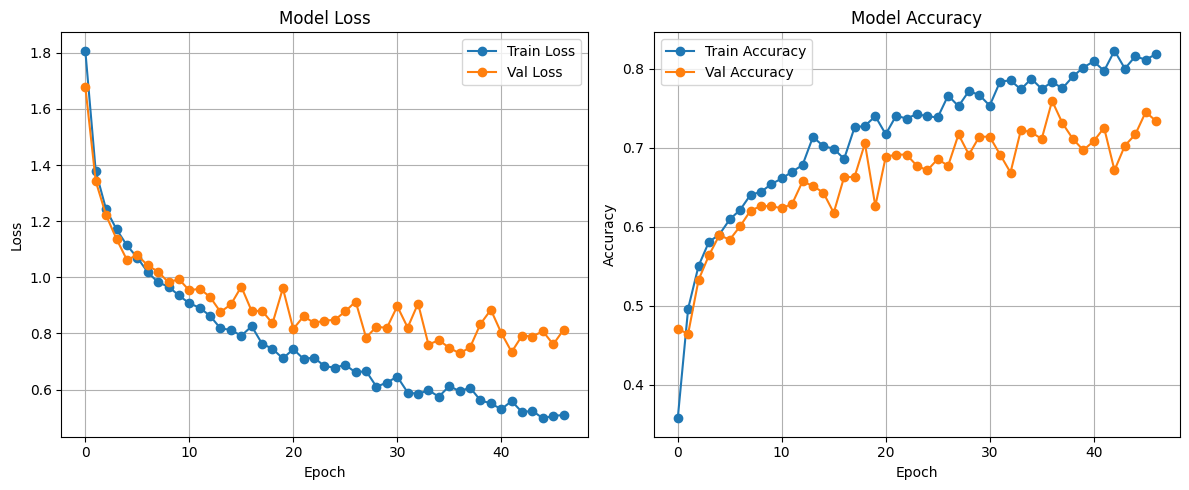

In [16]:
import matplotlib.pyplot as plt

# --- Plot training history ---
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


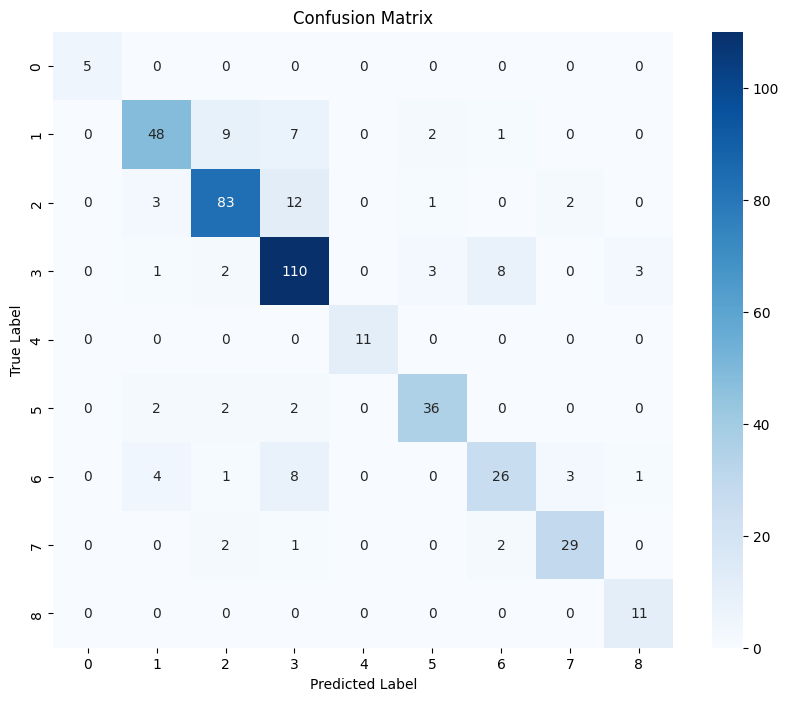

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      0.72      0.77        67
           2       0.84      0.82      0.83       101
           3       0.79      0.87      0.82       127
           4       1.00      1.00      1.00        11
           5       0.86      0.86      0.86        42
           6       0.70      0.60      0.65        43
           7       0.85      0.85      0.85        34
           8       0.73      1.00      0.85        11

    accuracy                           0.81       441
   macro avg       0.84      0.86      0.85       441
weighted avg       0.81      0.81      0.81       441



In [17]:
# --- Evaluate Model on Test Set ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert softmax probs to class indices

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


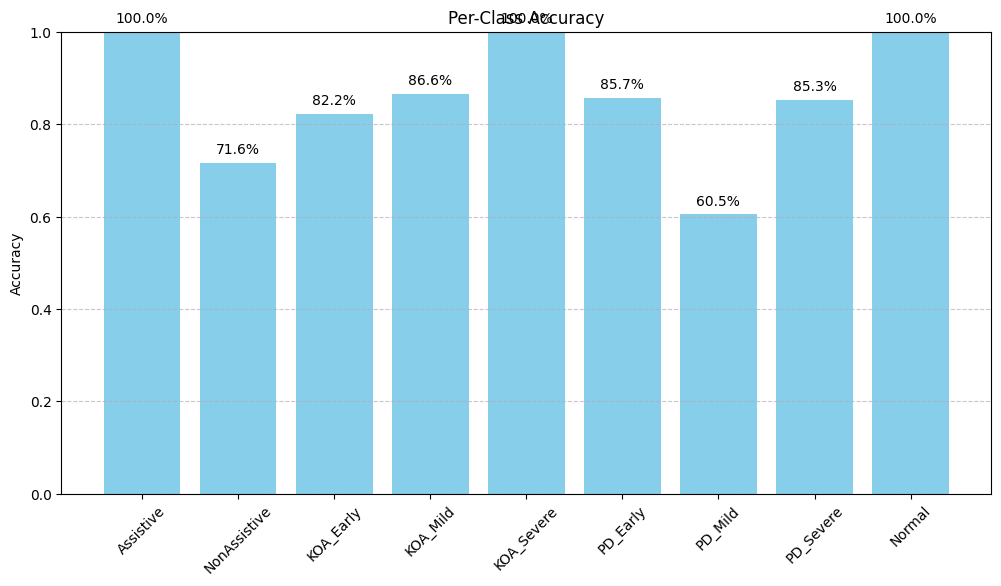

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = [
    'Assistive', 'NonAssistive', 
    'KOA_Early', 'KOA_Mild', 'KOA_Severe', 
    'PD_Early', 'PD_Mild', 'PD_Severe', 'Normal'
]

# Predict classes
y_pred_classes = model.predict(X_test).argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Plot
plt.figure(figsize=(12,6))
plt.bar(class_names, per_class_acc, color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above bars
for i, acc in enumerate(per_class_acc):
    plt.text(i, acc + 0.02, f"{acc*100:.1f}%", ha='center')

plt.show()


